In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['plates.zip', 'sample_submission.csv']
After zip extraction:
['plates', '__MACOSX', '__notebook_source__.ipynb']


In [3]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [6]:
#разобьем тест на test и train, теперь каждая 6-я фото-ия хранится в папке test 
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3427.52it/s]


In [9]:
!ls train

cleaned  dirty


In [11]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
# все трансформации будут подряд проделываться.
train_transforms = transforms.Compose([
#     Сделаем аугментацию!
    transforms.RandomResizedCrop(224), # Вырежем кусочек 224 на 224
    transforms.RandomHorizontalFlip(),# Отразим еще по горизонтали 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Есть очень много сторонних библиотек,
# которые позволяют делать совершенно разные трансформации
# с изображениями, и это очень здорово потому что у нас датасет 
# (трейновый) маленький, возможно, там каких-то тарелок, нет.    
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),# Для начала мы изображение ужмём до размера 224 на 224, тот размер, на котором он предобучен
    transforms.ToTensor(),# нам нужно превратить изображения в тензор
# Третья трансформация, уже не такая тривиальная.
# Когда ResNet обучался на датасете с изображениями, эти изображения были немного предобработаны.
# Это было не изображение, в котором каждый канал -- от нуля до единицы.
# И чтобы нам наше изображение привести к такому же виду, на которых обучался изначальный ResNet,
# нам нужно сделать следующее: нам нужно от каждого канала, от красного, зелёного и синего, отнять вот такие константы.
# Эти значения мы отнимем от соответствующих каналов, а потом нам нужно ещё поделить вот на такие константы.     
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Он предоставляет нам возможность итерироваться 
# по изображением и получает пары - изображение и его метка.
# Берёт он метки из тех папок, в которых лежат изображения, 
# то есть, если мы на вход ему передадим папку train,
# в этой папке train находится две дочерние папки -- это cleaned и dirty.
# И когда у нас ImageFolder будет отдавать изображения,
# он к каждому изображению ещё запомнит: а в какой же папке оно лежало -- в cleaned или dirty,
# и в каждой паре, будет не только изображение а ещё и класс. 

# И если у вас датасет сформирован именно таким образом 
# (то есть у вас изображения находятся в папках с классами и вы родительскую папку передаёте в ImageFolder),
# то ImageFolder, итерируясь по изображениям, отдаёт ещё название родительской папки 
# -- это такой способ хранения датасетов для классификации

#  Но если ImageFolder использовать без второго аргумента,
# это будут не pytorch тензоры, а нам надо их предобработать.

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

# А кроме того, нам нужны не тензоры из одного изображения -- нам нужны целые батчи из таких изображений,
# потому что нам хочется несколько изображений подавать в нейронку и считать некоторую лосс-функцию сразу по нескольким.
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size) #num_workers - что бы распараллелить
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

если мы посмотрим на его длину, то там окажется, что там 4 батча -- потому, что у нас всего 32 картинки остались в трейне, и если скомпоновать их по 8 изображений, получиться 4 батча.

Есть некоторый тонкий момент, что если у вас количество изображений не делится нацело на размер батча, то последний батч будет неполным. И иногда это играет некоторую роль. Опытные дата сайентисты делают всегда проверку, что у вас последний батч, если он неполный, не участвует в обучении нейронной сети, потому что там могут быть какие-то неправильные статистики, то есть вы необязательно хотите чтобы у вас по одному изображению считались градиенты и делался какой-то градиентный шаг.

In [12]:
len(train_dataloader), len(train_dataset)

(4, 32)

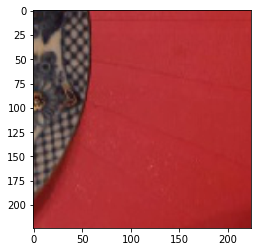

In [13]:
# Попросим первый батч
X_batch, y_batch = next(iter(train_dataloader))
# И, чтобы посмотреть на эти изображения, которые выходят из dataloader,
# нам нужно сделать обратные операции к тому transform, который происходил выше.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
когда у нас выполся to tensor, у нас  поменялся порядок размерностей изображения: 
у нас в изображении было -- высота, ширина, потом каналы.
Когда мы превратили это в тензор, то у нас были каналы, потом высота, потом ширина.
Веренем на место с помощью permute
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

Давайте вот из этих четырех строчек составим функцию, чтобы можно было быстро вызывать её и смотреть на изображения, которые получаются у нас в data loader.

Иногда бывает момент, что мы вырезаем очень маленькие кусочки, и по этим кусочкам ничего определить невозможно. Например, вот тут неочевидно, что это чистая тарелка, то есть, если у вас, например, вырежется просто кусок стола и сеть будет штрафоваться за то, что она неправильно определила класс -- это, наверное, будет не очень хороший сигнал, и тогда нужно будет изменить параметры random size crop, чтобы он вырезал большие участки. С флипами все норм

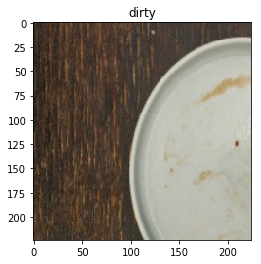

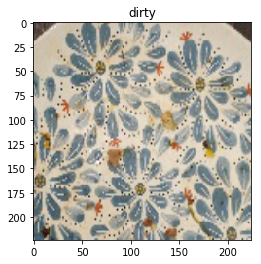

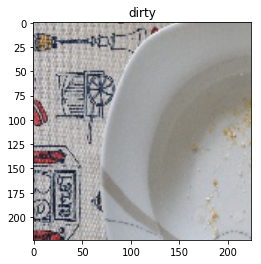

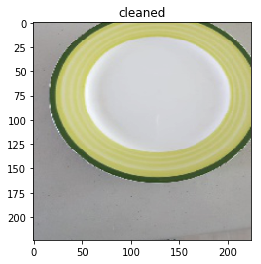

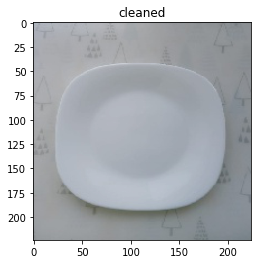

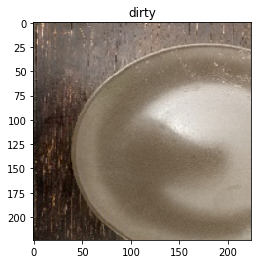

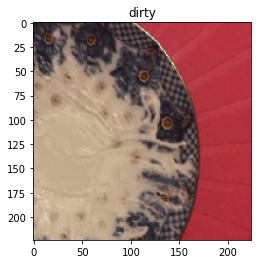

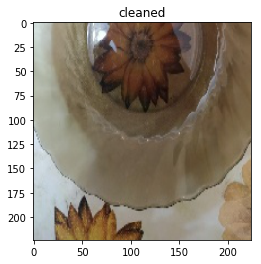

In [16]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [19]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step() #каждую эпоху по одному шагу 
#ВАЖНО 
#  Даже если у нас не выполняется backward, даже если мы не считаем градиенты и не изменем веса, 
# тем не менее в "форвард пассе" у нас могут изменяться параметры слоя батч-нормализации. 
# Может быть, есть ещё какие-то слои, которые изменяются с течением форвард пасса, и, чтобы этого не происходило,
# в фазе валидации, мы должны зафиксировать всю модель. 

                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
# Что она делает? Во время валидации, мы отключам подстчет градиента и сохрадяем только значения loss
# без промежуточных вычислений 
                    preds = model(inputs) #считаем предсказания 
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

Я делаю очень хитрый трюк, который очень часто делают, когда у вас очень маленький датасет. Дело в том, что когда у вас всего 40 изображений, то, наверное, вы не хотите переобучать весь ResNet, то есть все 18 слоёв, которые хорошо обучены распознавать тысячу классов. Мы, наверное, захотим обучать только последние слои, как раз -- там, где происходит классификация. В идеале мы обучим один полносвязанный слой, который находится в конце. Можно про это думать так -- что у вас из изображения вытаскиваются некоторые признаки, некоторые фичи. Это некоторый вектор (размером 512, в данном случае). И далее этот вектор просто используется как признаковое описание объекта, и на этом векторе в 512 у нас обучается полносвязанный слой, который даёт нам классификацию -- грязная тарелка или чистая.

И чтобы заморозить все эти веса, чтобы не использовать эти веса в обучении, а обучать только последний слой, мы сделаем следующий трюк: мы пойдем по параметрам модели (каждый параметр -- это каждый слой, model.parameters нам отдаст некоторый итератор по слоям). И для каждого параметра, для каждого слоя, мы скажем: "requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать. Но теперь нам нужно сделать ещё одну вещь -- нам нужно поменять последний полносвязанный слой, потому что полносвязанный слой, которые в ResNet по умолчанию -- он классифицирует на тысячу классов, а у нас класса всего 2. 

Поэтому мы сделаем следующее -- мы создадим слой torch.nn.Linear, это полносвязный слой, на вход он принимает model.fc_in.features (512). То есть 512, нейронов на вход приходит, и на выход нам нужно два нейрона, то есть два класса. И теперь model fc, то есть вот этот полносвязанный слой в ResNet будет выглядеть таким образом. И, так как по умолчанию там градиенты всегда считаются, то у нас, это единственный слой, который разморожен.

In [17]:
# "18" говорит о том, что там 18 слоёв, то есть обычно ResNet-50 берётся, здесь -- уменьшенная версия
# Мы скажем, что нам нужен он в формате pre trained, 
# то есть нам нужны веса, которые получились вследствие обучения этого ResNet, на датасете ImageNet
model = models.resnet18(pretrained=True) #модель, то есть архитектура

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss() #это лосс-функция
optimizer = torch.optim.Adam(model.parameters(),amsgrad= True, lr=1.0e-3) #метод градиентного спуска
# amsgrad делает его более правильным
# Decay LR by a factor of 0.1 every 7 epochs
# планировщик того, как будет уменьшаться шаг градиентного спуска, в некоторых случаях улучшает качество сходимости .
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 121193800.42it/s]


In [20]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

train Loss: 0.9240 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

val Loss: 0.7663 Acc: 0.5000
Epoch 1/9:



100%|██████████| 4/4 [00:00<00:00,  8.99it/s]

train Loss: 0.7670 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

val Loss: 0.6763 Acc: 0.5000
Epoch 2/9:



100%|██████████| 4/4 [00:00<00:00,  8.75it/s]

train Loss: 0.7786 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.6407 Acc: 0.7500
Epoch 3/9:



100%|██████████| 4/4 [00:00<00:00,  8.94it/s]

train Loss: 0.6628 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

val Loss: 0.6117 Acc: 0.7500
Epoch 4/9:



100%|██████████| 4/4 [00:00<00:00,  9.25it/s]

train Loss: 0.5590 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.5976 Acc: 0.8750
Epoch 5/9:



100%|██████████| 4/4 [00:00<00:00,  9.13it/s]

train Loss: 0.5492 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

val Loss: 0.6010 Acc: 0.6250
Epoch 6/9:



100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

train Loss: 0.5812 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.5826 Acc: 0.6250
Epoch 7/9:



100%|██████████| 4/4 [00:00<00:00,  8.89it/s]

train Loss: 0.5169 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.5616 Acc: 0.7500
Epoch 8/9:



100%|██████████| 4/4 [00:00<00:00,  9.14it/s]

train Loss: 0.5896 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.5631 Acc: 0.6250
Epoch 9/9:



100%|██████████| 4/4 [00:00<00:00,  9.13it/s]

train Loss: 0.5185 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

val Loss: 0.5660 Acc: 0.8750


Теперь, когда у нас есть обученная нейронная сеть, мы можем начать предсказывать на новых изображениях, на тестовом датасете

как вы помните, ImageFolder -- он принимал на вход путь к папке, в которой есть некоторые папки с классами. У нас был путь к папке "train", а внутри папки "train" был cleaned и dirty, и к сожалению, ImageFolder не сможет вам обработать путь к папке, в которой уже сразу лежат изображения, а у нас в тестовой директории уже сразу лежат изображения. И поэтому нам нужно сделать некоторый хак, то есть скопировать всю папку в тест -- в папку "test/unknown". Вот -- эта ячейка делает ровно это. То есть, мы должны сделать некоторую папку -- я назвал её "unknown" (неважно, как она называется), это будет тот лейбл, который будет проставляться изображениям. Данная схема позволяет формировать итератор по изображениям.

In [21]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

Вторая проблема, которую мы ещё не победили -- это то, что мы не знаем, какие ID, какие названия изображения у нас генерируется, когда мы просим у DataLoader -- "дай нам следующий батч". Они по алфавиту идут или по дате создания, или просто случайным образом -- непонятно. Поэтому нам нужно переписать немножко ImageFolder, чтобы он нам отдавал не просто tuple, с самим изображением и его меткой, а ещё, чтобы он отдавал имя, ну, либо -- путь к изображению. И для этого я написал этот класс -- 6 строчек, который наследуется от ImageFolder, но изменяет его функцию get_item. Если раньше она отдавала original tuple, то теперь этот original tuple я дополняю ещё путем к изображению. 

In [22]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [23]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

Переведём, опять, модель в evaluation состояние, то есть там не будет никаких изменений внутри происходить. Мы жёстко зафиксировали все веса и все параметры нейронной сети. И далее следует цикл: мы берём test DataLoader, получаем batch с изображениями, получаем их лейблы (тут лейбл не нужен совсем, потому что он всегда будет "unknown"), и получаем пути. Далее -- перегоняем наш тензор на GPU. И далее -- считаем prediction нашей модели. И после этого, prediction можно, с помощью с функции softmax, превратить к "от нуля до единицы", к вероятности первого класса. 

In [24]:
model.eval()

test_predictions = [] #наши предсказания
test_img_paths = [] # пути до изображений
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
# На вход подаются prediction, и на выходе у вас уже вероятности для 0 класса и для 1 класса.
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 24.20it/s]


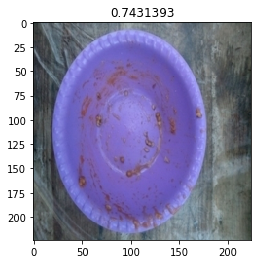

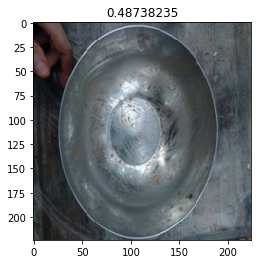

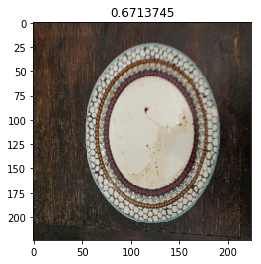

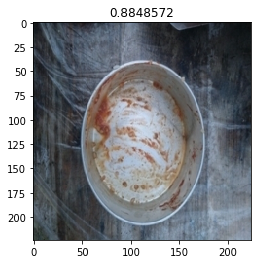

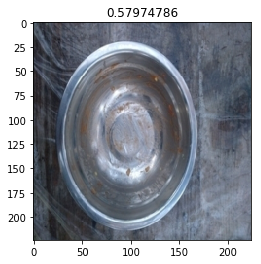

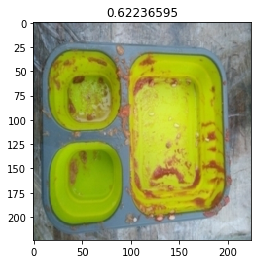

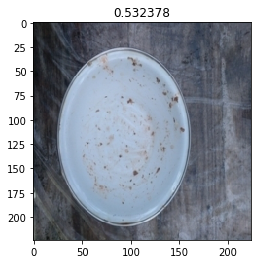

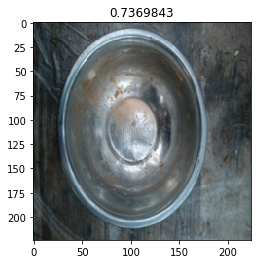

In [25]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

Теперь наши prediction нужно поместить в файл CSV -- это делается с помощью библиотеки Pandas. Мы можем сделать там некоторый объект dataframe, из двух list сделать две колонки, немножко поработать с самими колонками, потому что у нас ID -- это, пока что, пути до изображения, а нам нужны именно ID, то есть четыре цифры, которые соответствуют ID изображения. И после того, как мы проделаем все эти вещи, у нас получится такой вот CSV-файл, у которого будет ID и лэйблы -- "dirty" или "cleaned".

In [26]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [27]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,cleaned
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [28]:
submission_df.to_csv('submission.csv')

вот такой вот очень тонкий момент, который в принципе не сильно важен, если вы это делаете не на платформе kaggle, а у себя на компьютере): так как мы создавали train/val/test в текущей директории, то kaggle очень сильно ругается и ломается, если вы создайте очень много файлов, и поэтому в конце этого ноутбука неплохо было бы почистить те папки, которые уже не нужны -- папки с нашими датасетами, которые мы создали сами,

In [29]:
!rm -rf train val test